In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.coco import CocoGenerator
from keras_retinanet.preprocessing.url_generator import UrlGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load RetinaNet model

In [20]:
model = keras.models.load_model('snapshots/resnet50_coco_best.h5', custom_objects=custom_objects)

/home/xpitfire/anaconda3/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_2" during training.
  sample_weight_mode=sample_weight_mode)


In [ ]:
print(model.summary())

## Initialize data generators

In [ ]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CocoGenerator(
    'C:\\Users\\celum\\source\\data',
    'val2017'
)

## Run detection on validation example

In [ ]:
index = 0

In [ ]:
# load image
image = val_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)
index += 1

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(val_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Run detection on custom image

In [21]:
urls = [
    'https://www.travellers-insight.com/wp-content/uploads/2017/05/Travellers-Insight-Reiseblog-Tokio-Highlights-Shibuya.jpg',
    'https://i.stack.imgur.com/H03KE.png',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Pilies_Street_at_dusk%2C_Vilnius%2C_Lithuania_-_Diliff.jpg/1200px-Pilies_Street_at_dusk%2C_Vilnius%2C_Lithuania_-_Diliff.jpg',
    'http://idolza.com/a/f/t/the-office-desk-guide-gentlemans-gazette-credenza_office-desk-modern_interior-design-firms-home-office-ideas-your-house-modern-floor-plans-contemporary-room-architecture-and.jpg',
    'http://www.socialjin.com/wp-content/uploads/2016/05/88762487_junk_food.jpg'
]
classes_path = './data/coco/classes.json'
labels_path = './data/coco/labels.json'

In [22]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = UrlGenerator(urls, classes_path, labels_path)

processing time:  0.6127462387084961


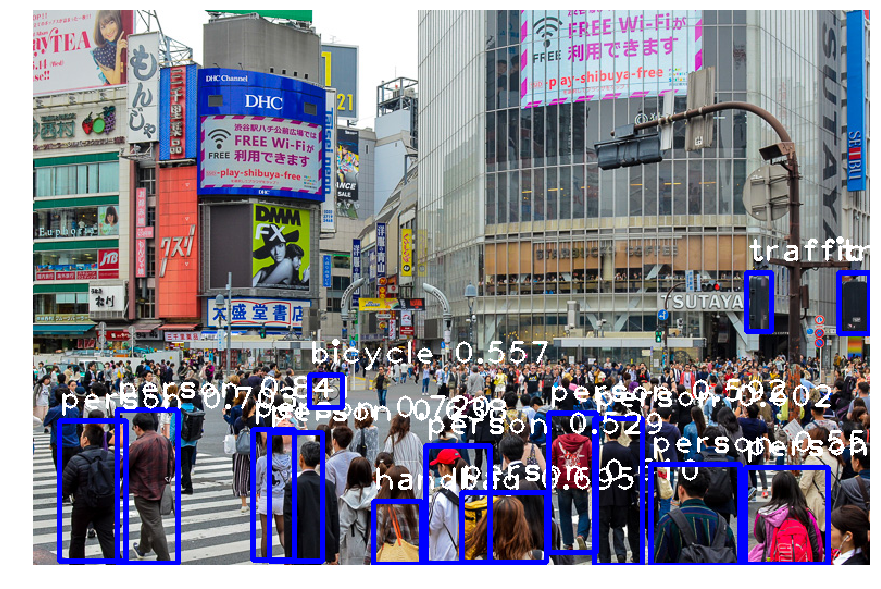

processing time:  0.34755396842956543


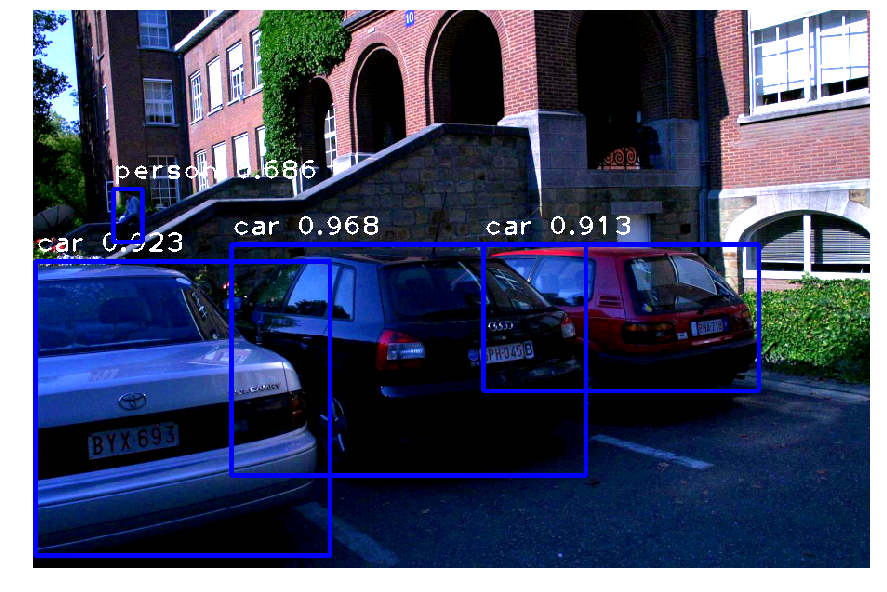

processing time:  0.08778071403503418


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


processing time:  0.47571301460266113


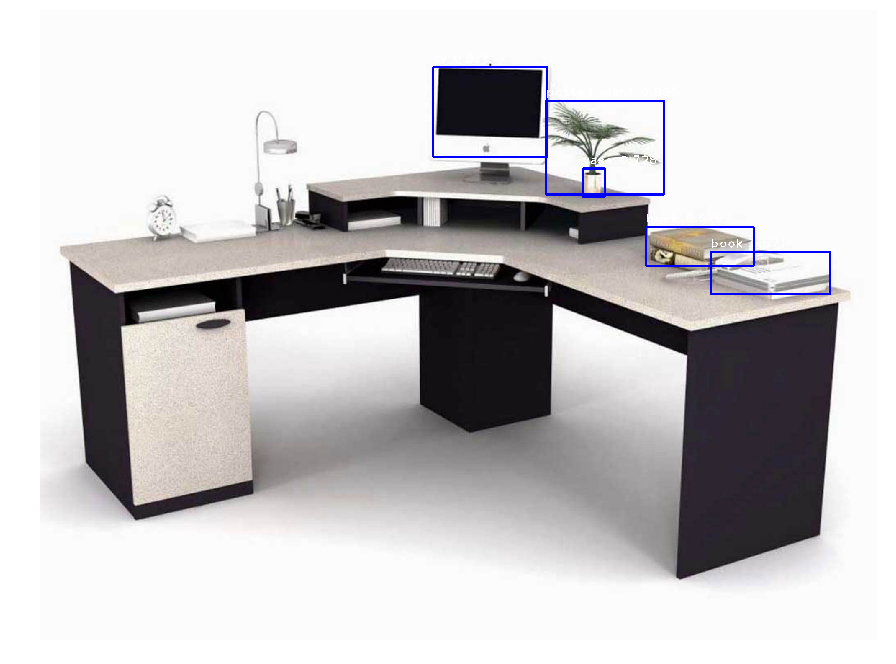

processing time:  0.3618497848510742


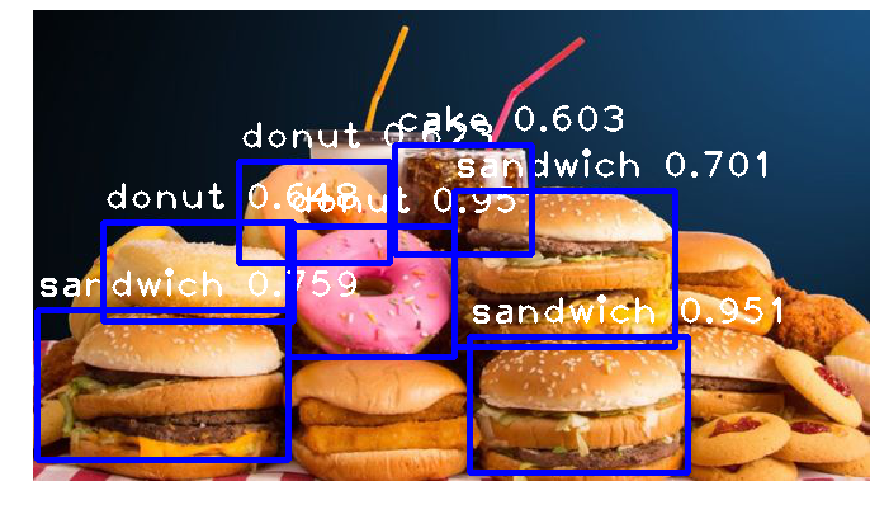

In [23]:
# load image
for i in range(len(urls)):
    image = val_generator.read_image_bgr(i)

    # copy to draw on
    draw = np.asarray(image.copy())
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = val_generator.preprocess_image(image)
    image, scale = val_generator.resize_image(image)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.5:
            continue
        b = detections[0, idx, :4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 2)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()